# Padding and masking layer in keras

Here a simple summary adn reasoning for the code.


1. Data Generation and Preprocessing:

Our model is designed to work with 2 to 4 features. The underlying function we're trying to approximate is:
```
f(x₁, x₂, x₃, x₄) = 2x₁² + 3x₂ - 1.5x₃ + 0.5x₄ + ε
````

Where `ε` is random noise $(N(0, 0.5²))$, and `x₃` and `x₄` may or may not be present.

2. Padding:

For inputs with fewer than 4 features, we pad with zeros:

```
[x₁, x₂] → [x₁, x₂, 0, 0]
[x₁, x₂, x₃] → [x₁, x₂, x₃, 0]
````

3. Normalization:

We normalize each feature independently:

```
x'ᵢ = (xᵢ - μᵢ) / σᵢ
````

Where μᵢ and σᵢ are the mean and standard deviation of the i-th feature.

4. Masking:

We create a binary mask M where:
Mᵢ = 1 if xᵢ is an actual feature
Mᵢ = 0 if xᵢ is a padded value (0)

5. Neural Network Architecture:

Our network consists of:
- Input layer (4 neurons)
- Masking layer
- Dense layer 1 (32 neurons, ReLU activation)
- Dense layer 2 (32 neurons, ReLU activation)
- Output layer (1 neuron, linear activation)

6. Forward Pass:

Let's denote the weight matrices as W¹, W², W³ and bias vectors as b¹, b², b³.

a) First, the masking layer zeros out the padded values:
x_masked = x'⊙ M  (where ⊙ is element-wise multiplication)

b) Then, for each dense layer:

```
h¹ = ReLU(W¹x_masked + b¹)
h² = ReLU(W²h¹ + b²)
y = W³h² + b³
````

Where ReLU(z) = max(0, z)

7. Loss Function:

We use Mean Squared Error (MSE):

$L = 1/n \sum_i(y_i - \hat{y}_i)^2$

Where y is the true (normalized) output and ŷ is the model's prediction.

## Reasoning

The key to handling variable features is the masking layer. It ensures that during both training and inference:
1. Padded values (zeros) don't contribute to the network's computations.
2. The network learns to ignore these padded values.
3. The same model can handle inputs with different numbers of features without changing its architecture.

This approach allows our single model to approximate the function for 2, 3, or 4 features without needing separate models or conditional logic in the network itself. The masking effectively "turns off" the parts of the network corresponding to missing features, allowing it to adapt to the input dimension dynamically.


In [497]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Force TensorFlow to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

# Generate synthetic data with variable number of features
np.random.seed(0)

Training device: CPU


In [498]:
masking_value = 0.

# Data Generation adn Padding

In [499]:
num_samples = 1000

def generate_sample(num_features):
    X = np.random.randn(num_features).astype(np.float32)
    y = (2 * X[0]**2 + 3 * X[1] + 
         (-1.5 * X[2] if num_features > 2 else 0) + 
         (0.5 * X[3] if num_features > 3 else 0) + 
         np.random.normal(0, 0.8)).astype(np.float32)
    return X, y

X = []
y = []

for _ in range(num_samples):
    num_features = np.random.choice([2, 3, 4])
    sample_X, sample_y = generate_sample(num_features)
    X.append(sample_X)
    y.append(sample_y)



# Padding 
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=4, padding='post', dtype='float32', value=masking_value)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Normalization
X_mean, X_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
y_mean, y_std = np.mean(y_train), np.std(y_train)

X_train_norm = (X_train - X_mean) / X_std
X_val_norm = (X_val - X_mean) / X_std
y_train_norm = (y_train - y_mean) / y_std
y_val_norm = (y_val - y_mean) / y_std

In [500]:
print(X_train[:10])

[[-1.2910584  -1.0300188  -0.5174519   0.        ]
 [-0.23889631 -0.24901256  0.          0.        ]
 [ 0.11186542 -0.48113996  1.0440012   0.        ]
 [-2.9214175  -0.6843345   0.          0.        ]
 [-0.19856341 -2.4203782  -0.7165171  -1.1771753 ]
 [ 0.49079394  2.1587539   0.6734681   0.47978786]
 [ 0.5152652  -0.28143394  0.          0.        ]
 [-0.38951838  0.32478485  0.          0.        ]
 [ 0.58229244 -1.5496509   0.          0.        ]
 [-0.61827    -0.5904416  -0.59014416  0.        ]]


## Model

In [523]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Masking, Dense
from tensorflow.keras.models import Model

class CustomMaskedDense(Layer):
    def __init__(self, units, **kwargs):
        super(CustomMaskedDense, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.bias = self.add_weight(name='bias', 
                                    shape=(self.units,),
                                    initializer='zeros',
                                    trainable=True)
        super(CustomMaskedDense, self).build(input_shape)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = tf.cast(mask, dtype=inputs.dtype)
            mask = tf.expand_dims(mask, -1)
            inputs *= mask
        output = tf.matmul(inputs, self.kernel) + self.bias
        return tf.nn.relu(output)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

    def compute_mask(self, inputs, mask=None):
        return mask

def build_model(input_shape, mask_value, hidden_units, weights=None):
    inputs = Input(shape=input_shape)
    if mask_value is not None:
        masked_inputs = Masking(mask_value=mask_value)(inputs)
    else:
        masked_inputs = inputs
    custom_dense_layer = CustomMaskedDense(hidden_units)(masked_inputs)
    output = Dense(1, activation='sigmoid')(custom_dense_layer)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    if weights is not None:
        model.set_weights(weights)
    return model

# Sample data with padding (0 is the padding value)
masked_data = np.array([[1, 2, 3, 999, 999], [4, 5, 6, 7, 999]])
non_masked_data = np.array([[1, 2, 3, 0, 0], [4, 5, 6, 7, 0]])
labels = np.array([1, 0])

# Create and train the model on masked data
masked_nn = build_model(input_shape=(5,), mask_value=999, hidden_units=10)
masked_nn.fit(masked_data, labels, epochs=10, verbose=0)

# Extract weights after training on masked data
weights = masked_nn.get_weights()

# Create a new model with the same weights for non-masked data
non_masked_nn = build_model(input_shape=(5,), mask_value=None, hidden_units=10, weights=weights)

# Predict using both models
masked_output = masked_nn.predict(masked_data)
non_masked_output = non_masked_nn.predict(non_masked_data)

print("Masked data output:", masked_output)
print("Non-masked data output:", non_masked_output)


1/1 [==============================] - 0s 47ms/step
Masked data output: [[9.9999619e-01]
 [2.9157823e-09]]
Non-masked data output: [[0.5593259]
 [0.6434154]]


In [501]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# class CustomMaskingDenseLayer(layers.Layer):
#     def __init__(self, units, **kwargs):
#         super().__init__(**kwargs)
#         self.units = units
#         self.supports_masking = True
#         self.dense = layers.Dense(units)
    
#     def call(self, inputs, mask=None):
#         output = self.dense(inputs)
#         if mask is not None:
#             mask = tf.cast(mask, dtype=output.dtype)
#             mask = tf.expand_dims(mask, axis=-1)
#             output_shape = tf.shape(output)
#             mask = tf.broadcast_to(mask, output_shape)
#             output *= mask
#         return output
    
#     def compute_mask(self, inputs, mask=None):
#         return mask

# class CustomModel(keras.Model):
#     def __init__(self, output_units, **kwargs):
#         super(CustomModel, self).__init__(**kwargs)
#         self.dense1 = CustomMaskingDenseLayer(output_units)
#         self.dense2 = CustomMaskingDenseLayer(32)
#         self.output_layer = CustomMaskingDenseLayer(1)
    
#     def call(self, inputs, training=None, mask=None):
#         x = self.dense1(inputs, mask=mask)
#         x = self.dense2(x, mask=mask)
#         return self.output_layer(x, mask=mask)
    
#     def train_step(self, data):
#         x, y = data
        
#         with tf.GradientTape() as tape:
#             y_pred = self(x, training=True)
#             loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        
#         gradients = tape.gradient(loss, self.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
#         self.compiled_metrics.update_state(y, y_pred)
        
#         return {m.name: m.result() for m in self.metrics}

# # Create a sample input data and a corresponding mask
# input_data = tf.random.normal([10, 5])  # 10 examples, 5 features each
# mask = tf.constant([[1, 1, 1, 0, 0],  # First example: mask last two features
#                     [1, 1, 1, 1, 1],  # Second example: no masking
#                     [0, 0, 0, 0, 0],  # Third example: all features masked
#                     [1, 1, 1, 1, 1],
#                     [1, 0, 1, 0, 1],
#                     [1, 1, 1, 1, 0],
#                     [1, 1, 1, 1, 1],
#                     [0, 0, 0, 1, 1],
#                     [1, 1, 1, 1, 1],
#                     [1, 0, 0, 0, 0]], dtype=tf.float32)  # More examples...

# # Instantiate the model
# model = CustomModel(output_units=5)
# model.compile(optimizer='adam', loss='mse')

# # Predict without mask
# outputs_no_mask = model(input_data)

# # Predict with mask
# outputs_with_mask = model(input_data, mask=mask)

# # Print outputs to compare
# print("Outputs without Mask:\n", outputs_no_mask.numpy())
# print("Outputs with Mask:\n", outputs_with_mask.numpy())

# # Check where the differences occur
# difference = tf.reduce_sum(tf.abs(outputs_no_mask - outputs_with_mask))
# print("Difference in outputs:", difference.numpy())

# Init 

In [502]:
# Instantiate the mode
output_units = 1
model = CustomModel(output_units)
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Custom training loop
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def val_step(x, y):
    predictions = model(x, training=False)
    loss = loss_fn(y, predictions)
    return loss

### Training

Epoch 10, Loss: 0.4952, Val Loss: 0.4226
Epoch 20, Loss: 0.4903, Val Loss: 0.4195
Epoch 30, Loss: 0.4944, Val Loss: 0.4139
Epoch 40, Loss: 0.4917, Val Loss: 0.4161
Epoch 50, Loss: 0.4917, Val Loss: 0.4159
Epoch 60, Loss: 0.4934, Val Loss: 0.4161
Epoch 70, Loss: 0.4998, Val Loss: 0.4293
Epoch 80, Loss: 0.4892, Val Loss: 0.4235
Epoch 90, Loss: 0.4921, Val Loss: 0.4261
Epoch 100, Loss: 0.4922, Val Loss: 0.4176
Epoch 110, Loss: 0.4935, Val Loss: 0.4147
Epoch 120, Loss: 0.4893, Val Loss: 0.4215
Epoch 130, Loss: 0.4912, Val Loss: 0.4259
Epoch 140, Loss: 0.4881, Val Loss: 0.4160
Epoch 150, Loss: 0.4928, Val Loss: 0.4132
Epoch 160, Loss: 0.4899, Val Loss: 0.4159
Epoch 170, Loss: 0.4943, Val Loss: 0.4171
Epoch 180, Loss: 0.4919, Val Loss: 0.4178
Epoch 190, Loss: 0.4925, Val Loss: 0.4165
Epoch 200, Loss: 0.4899, Val Loss: 0.4165


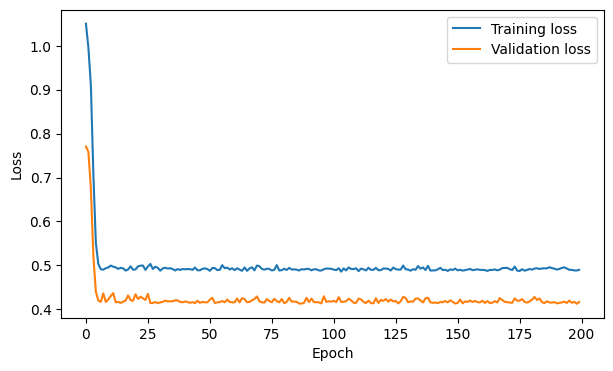

In [503]:
# Training
epochs = 200
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train_norm.reshape(-1, 1))).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val_norm.reshape(-1, 1))).batch(batch_size)

train_losses = []
val_losses = []

for epoch in range(epochs):
    epoch_train_losses = []
    epoch_val_losses = []
    
    for x_batch, y_batch in train_dataset:
        train_loss = train_step(x_batch, y_batch)
        epoch_train_losses.append(train_loss)
    
    for x_val_batch, y_val_batch in val_dataset:
        val_loss = val_step(x_val_batch, y_val_batch)
        epoch_val_losses.append(val_loss)
    
    train_losses.append(tf.reduce_mean(epoch_train_losses))
    val_losses.append(tf.reduce_mean(epoch_val_losses))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {train_losses[-1].numpy():.4f}, Val Loss: {val_losses[-1].numpy():.4f}')

# Plot the training and validation losses
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 [==============================] - 0s 1ms/step


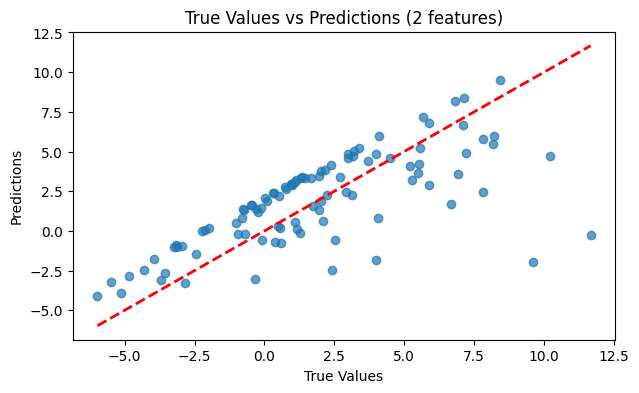

4/4 [==============================] - 0s 1ms/step


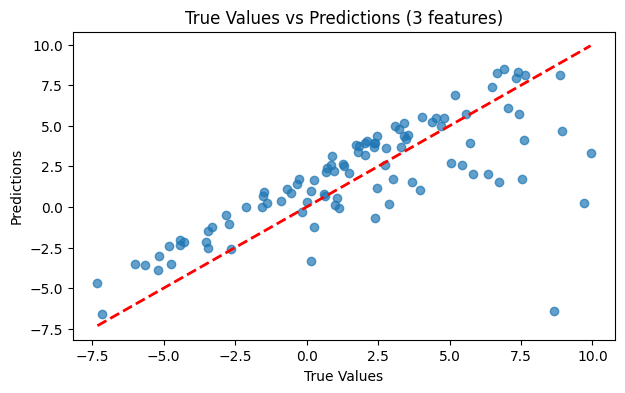

4/4 [==============================] - 0s 1ms/step


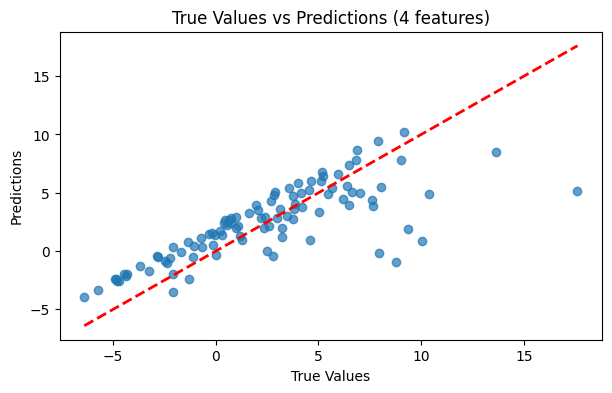

1/1 [==============================] - 0s 23ms/step

Prediction for 2 features:
Input X = [-0.7853214 -2.1645515]
Predicted y: -4.07
True y: -5.26
1/1 [==============================] - 0s 23ms/step

Prediction for 3 features:
Input X = [ 1.1445812 -0.9505018  0.7641232]
Predicted y: -1.61
True y: -1.38
1/1 [==============================] - 0s 23ms/step

Prediction for 4 features:
Input X = [ 1.3194897  -0.12032467 -1.0543095  -2.7589276 ]
Predicted y: 1.66
True y: 3.32


In [504]:
def prepare_test_data(num_features):
    X_test = np.random.randn(100, num_features).astype(np.float32)
    y_test = np.zeros(100, dtype=np.float32)
    
    y_test += 2 * X_test[:, 0]**2
    y_test += 3 * X_test[:, 1]
    if num_features > 2:
        y_test += -1.5 * X_test[:, 2]
    if num_features > 3:
        y_test += 0.5 * X_test[:, 3]
    
    X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=4, padding='post', dtype='float32')
    X_test_norm = (X_test_padded - X_mean) / X_std
    
    return X_test_norm, y_test

# Test for 2, 3, and 4 features
for num_features in [2, 3, 4]:
    X_test_norm, y_true = prepare_test_data(num_features)
    y_pred_norm = model.predict(X_test_norm)
    y_pred = y_pred_norm * y_std + y_mean

    plt.figure(figsize=(7, 4))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'True Values vs Predictions ({num_features} features)')
    plt.show()

# Make predictions
for num_features in [2, 3, 4]:
    new_X = np.random.randn(1, num_features).astype(np.float32)
    new_X_padded = tf.keras.preprocessing.sequence.pad_sequences(new_X, maxlen=4, padding='post', dtype='float32')
    new_X_norm = (new_X_padded - X_mean) / X_std
    predicted_y_norm = model.predict(new_X_norm)
    predicted_y = predicted_y_norm * y_std + y_mean

    print(f"\nPrediction for {num_features} features:")
    print(f"Input X = {new_X[0]}")
    print(f"Predicted y: {predicted_y[0][0]:.2f}")
    true_y = (2 * new_X[0, 0]**2 + 3 * new_X[0, 1] + 
              (-1.5 * new_X[0, 2] if num_features > 2 else 0) + 
              (0.5 * new_X[0, 3] if num_features > 3 else 0))
    print(f"True y: {true_y:.2f}")